In [1]:
import os
import sys
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple, Dict, Any, Optional



In [18]:
INFO_TO_USE_FOR_CLUSTERING = ['exception_message', 'essential_file_content']

PCA_COMPONENTS = 3

AI_MODEL = "llama-3.1-70b-versatile"  # or "gpt-4o-mini"

N_POSITIVE_EXAMPLES_TO_SHOW_LLM = 5

In [3]:
PATH_GROQ_TOKEN = "../groq_token.txt"
GROQ_TOKEN = Path(PATH_GROQ_TOKEN).read_text().strip()
import groq

# Export the GROQ_TOKEN as GROQ_API_KEY
os.environ['GROQ_API_KEY'] = GROQ_TOKEN

PATH_OPENAI_API_KEY = "../openai_token.txt"
OPENAI_API_KEY = Path(PATH_OPENAI_API_KEY).read_text().strip()
import openai

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY


In [4]:
# Test run
# DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v001", "2024_10_04__14_48__qiskit")

# Run with 10k programs: v001.yaml
# program_bank/v001/2024_10_04__15_10__qiskit
# DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v001", "2024_10_04__15_10__qiskit")
# program_bank/v002/2024_10_07__17_03__qiskit
DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v002", "2024_10_07__17_03__qiskit")

In [6]:
from multiprocessing import Pool
import re

def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["error_file"] = os.path.basename(file_path)
        return data

def read_all_programs(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if re.match(r'.*_error\.json$', f)]
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)

# Use the function to read all programs
df_errors = read_all_programs(DIR_PROGRAM_BANK)

# augment the dataframe with the proram content
def read_file_content(file_name: str) -> str:
    file_path = os.path.join(DIR_PROGRAM_BANK, file_name)
    with open(file_path, 'r') as file:
        return file.read()

# Use parallel apply to read the file content
with Pool() as pool:
    df_errors['file_content'] = pool.map(read_file_content, df_errors['current_file'])

# Alternatively, you can use apply without parallel processing
# df_errors['file_content'] = df_errors['current_file'].apply(read_file_content)

df_errors.head()
n_errors = len(df_errors)
print(f"Number of errors: {n_errors}")


Number of errors: 27470


In [7]:
# Extract the essential file content between "# <START_GATES>" and "# <END_GATES>"
def extract_essential_content(file_content: str) -> str:
    start_marker = "# <START_GATES>"
    end_marker = "# <END_GATES>"
    start_index = file_content.find(start_marker)
    end_index = file_content.find(end_marker, start_index)
    if start_index != -1 and end_index != -1:
        return file_content[start_index + len(start_marker):end_index].strip()
    return ""

df_errors['essential_file_content'] = df_errors['file_content'].apply(extract_essential_content)

# Test case to check if the resulting essential_file_content has all lines starting with 'qc.'
def test_extract_essential_content():
    first_row_content = df_errors['file_content'].iloc[0]
    essential_content = extract_essential_content(first_row_content)
    lines = essential_content.split('\n')
    assert all(line.strip().startswith('qc.') for line in lines), "Not all lines start with 'qc.'"
    print("Test passed: All lines in the essential content start with 'qc.'")

# Run the test case
test_extract_essential_content()


Test passed: All lines in the essential content start with 'qc.'


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import random
from typing import List, Dict
from scipy.sparse import csr_matrix, vstack
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer


def run_analysis(df: pd.DataFrame, n_clusters: int, input_columns: List[str] = ['exception_message']) -> pd.DataFrame:
    # Combine the specified columns into a single text column
    combined_text = df[input_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

    # Vectorize the text data
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(combined_text)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_

    # Add the cluster labels to the dataframe
    df['cluster'] = labels
    return df

def plot_clusters(df: pd.DataFrame):
    # Visualize the results using a bar plot
    plt.figure(figsize=(10, 6))
    sns.countplot(x='cluster', data=df)
    plt.title('Number of Error Messages per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Error Messages')
    plt.show()

def stratified_sampling(data, labels, sample_size=100) -> Tuple[np.ndarray, np.ndarray]:
    """Sample data points from each cluster.

    Arguments:
    - data: the data points as csr matrix
    - labels: the cluster labels of the data points [list of int]
    - sample_size: the number of samples to take from each cluster

    Implementation:
    first extract all the X representing data from the same cluster
    (using label information)
    then sample the data points from the cluster
    """
    map_label_to_data = {}
    for label in np.unique(labels):
        # Extract all data points from the same cluster
        X_cluster = data[labels == label]
        # Sample the data points
        if X_cluster.shape[0] > sample_size:
            X_sampled = X_cluster[np.random.choice(X_cluster.shape[0], sample_size, replace=False)]
        else:
            X_sampled = X_cluster
        # Store the sampled data points
        map_label_to_data[label] = X_sampled
    # concatenate the sampled data points
    for k, v in map_label_to_data.items():
        print(f'Cluster {k}: {v.shape[0]} data points')

    # concatenate data points from all clusters
    if isinstance(data, csr_matrix):
        X_sampled = vstack([X_cluster for X_cluster in map_label_to_data.values()])
    else:
        X_sampled = np.vstack([X_cluster.toarray() if isinstance(X_cluster, csr_matrix) else X_cluster for X_cluster in map_label_to_data.values()])
    # create the corresponding labels
    sampled_labels = []
    for label, X_cluster in map_label_to_data.items():
        sampled_labels.extend([label] * X_cluster.shape[0])
    nd_sampled_labels = np.array(sampled_labels)
    assert X_sampled.shape[0] == nd_sampled_labels.shape[0], 'The number of data points and labels should match'
    return X_sampled, nd_sampled_labels

# Test cases
def test_stratified_sampling():

    # Create a small dataset
    data = csr_matrix([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [0, 1, 1],
        [1, 0, 1]
    ])
    labels = np.array([0, 0, 1, 1, 2, 2])

    # Test with sample size less than the number of data points in each cluster
    X_sampled, sampled_labels = stratified_sampling(data, labels, sample_size=1)
    assert X_sampled.shape[0] == 3, "Test case 1 failed"
    assert len(np.unique(sampled_labels)) == 3, "Test case 1 failed"

    # Test with sample size more than the number of data points in each cluster
    X_sampled, sampled_labels = stratified_sampling(data, labels, sample_size=3)
    assert X_sampled.shape[0] == 6, "Test case 2 failed"
    assert len(np.unique(sampled_labels)) == 3, "Test case 2 failed"

    print("All test cases passed!")

# Run test cases
# test_stratified_sampling()

def find_optimal_k_silhouette(data, k_range: range = range(2, 11)) -> int:
    silhouette_scores = []
    random.seed(42)
    for k in k_range:
        print(f'Running K-Means with K={k}')
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)

        # Sample data points from each cluster
        X_sampled, sampled_labels = stratified_sampling(data, kmeans.labels_)

        # Compute silhouette score on the sampled data
        score = silhouette_score(X_sampled, sampled_labels)
        silhouette_scores.append(score)

    # Find the optimal k with the highest silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.show()
    return optimal_k

def find_optimal_k_knead(data, k_range: range = range(2, 11), n_reruns: int = 5) -> int:
    """
    Find the optimal number of clusters (k) for K-Means using the elbow method.
    Parameters:
    data (array-like): The input data to cluster.
    k_range (range, optional): The range of k values to evaluate.
                               Defaults to range(2, 11).
    n_reruns (int, optional): The number of reruns for each k value.

    Returns:
    int: The optimal number of clusters (k) determined by the elbow method.
    """

    distortions = []
    for k in k_range:
        print(f'Running K-Means with K={k}')
        # run the k-means n_reruns times and take the average
        distortions_k = []
        for _ in range(n_reruns):
            kmeans = KMeans(n_clusters=k, random_state=random.randint(0, 10000))
            kmeans.fit(data)
            distortions_k.append(kmeans.inertia_)
        distortions.append(np.mean(distortions_k))

    # Use KneeLocator to find the optimal k
    knee_locator = KneeLocator(k_range, distortions, curve='convex', direction='decreasing')
    optimal_k = knee_locator.elbow

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, distortions, marker='o')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Distortion')
    plt.show()

    return optimal_k


0    Gate has an invalid number of parameters qc.rx...
1    The circuits are not equivalent: /workspace/qi...
2    The circuits are not equivalent: /workspace/qi...
3    Could not import second circuit: <input>:3:6:\...
4    The circuits are not equivalent: /workspace/qi...
dtype: object


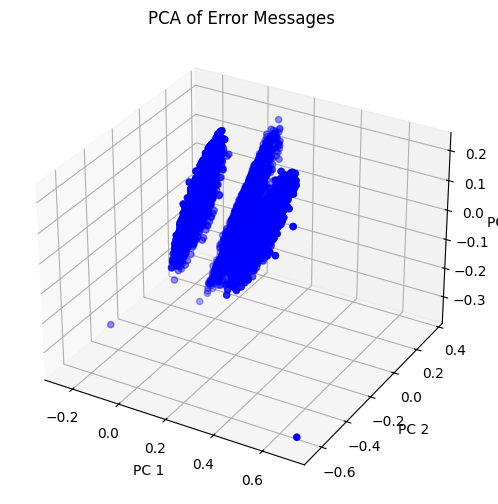

(27470, 3)
Running K-Means with K=2
Running K-Means with K=3
Running K-Means with K=4
Running K-Means with K=5
Running K-Means with K=6
Running K-Means with K=7
Running K-Means with K=8
Running K-Means with K=9
Running K-Means with K=10


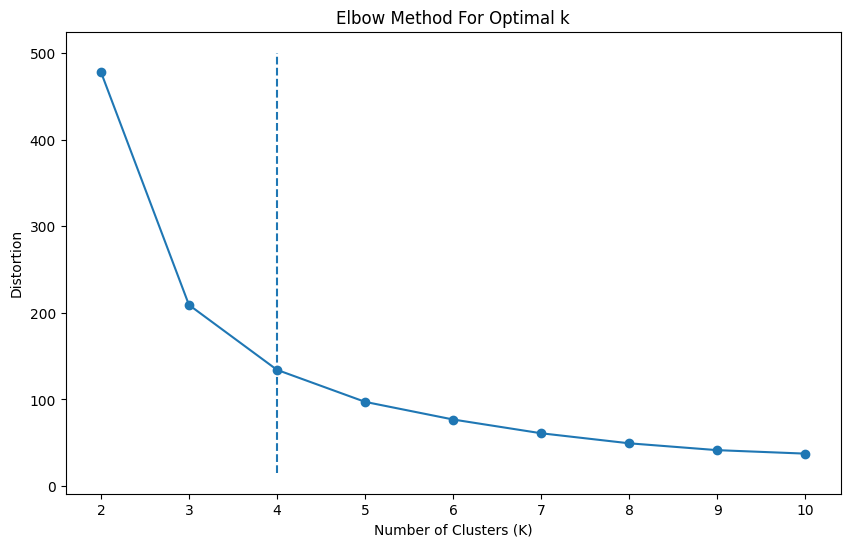

Optimal K (knead): 4


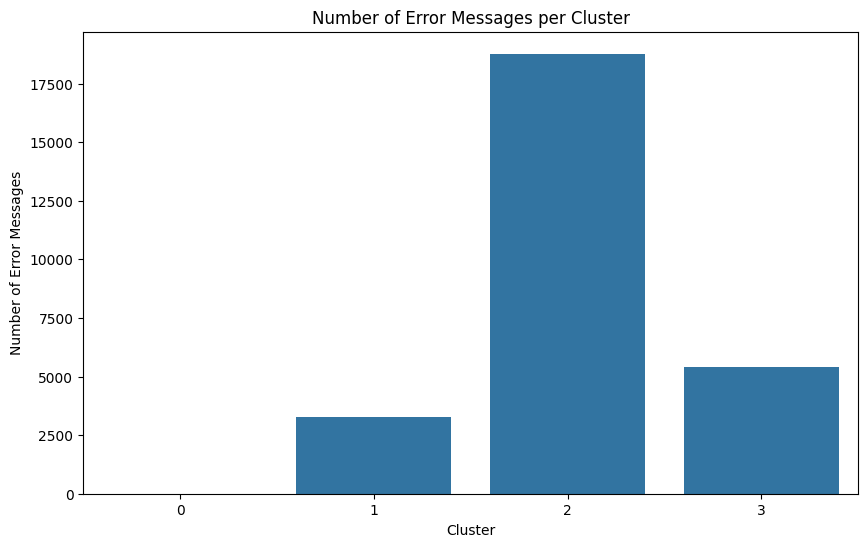

In [11]:
# Example usage
columns_to_use = INFO_TO_USE_FOR_CLUSTERING
combined_text = df_errors[columns_to_use].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
# print first 5 combined_text
print(combined_text[:5])

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_text)

# # Sentence embeddings
# print("Loading the model...")
# model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()
# print("Model loaded successfully!")
# X = model.encode(combined_text)
# print("data encoded successfully!")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=PCA_COMPONENTS)
X_reduced = pca.fit_transform(X)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c='b', marker='o')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('PCA of Error Messages')
plt.show()


print(X_reduced.shape)

X_data = X_reduced

# optimal_k = find_optimal_k_silhouette(X_data)
# print(f'Optimal K (silhouette): {optimal_k}')

optimal_k = find_optimal_k_knead(X_data)
print(f'Optimal K (knead): {optimal_k}')


# optimal_k = 3

# Update the number of clusters based on the optimal K
n_clusters = optimal_k

# run with the optimal K
df_errors = run_analysis(df_errors, n_clusters, input_columns=columns_to_use)
plot_clusters(df_errors)



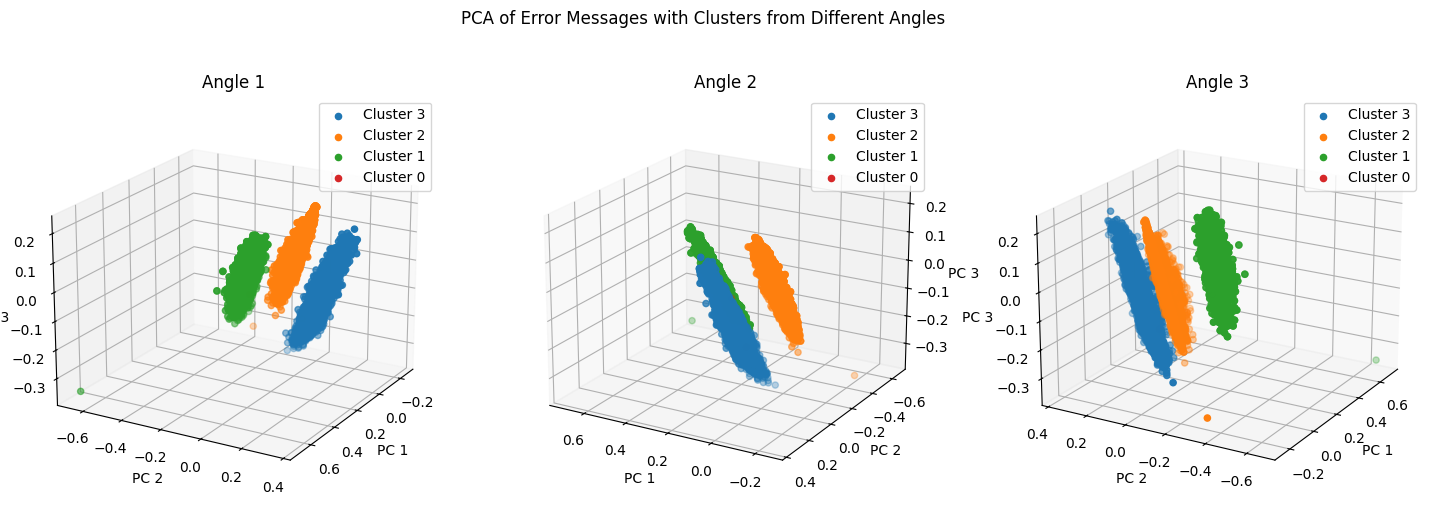

In [13]:
def plot_3d_clusters(df: pd.DataFrame, X_data: np.ndarray, angles: List[Tuple[int, int]], title: str = 'PCA of Error Messages with Clusters from Different Angles'):
    """
    Plot 3D clusters from different angles.

    Args:
    df (pd.DataFrame): DataFrame containing the cluster information.
    X_data (np.ndarray): Numpy array containing the PCA reduced data.
    angles (List[Tuple[int, int]]): List of tuples where each tuple contains (elev, azim) for the viewing angle.
    title (str): Title of the plot.
    """
    fig = plt.figure(figsize=(18, 6))

    for i, (elev, azim) in enumerate(angles):
        ax = fig.add_subplot(1, len(angles), i + 1, projection='3d')
        for cluster in df['cluster'].unique():
            cluster_data = X_data[df['cluster'] == cluster]
            ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], marker='o', label=f'Cluster {cluster}')
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f'Angle {i + 1}')
        ax.legend()

    plt.suptitle(title)
    plt.show()

# Example usage
angles = [(20, 30), (20, 120), (20, 210)]
plot_3d_clusters(df_errors, X_data, angles)


In [14]:
df_errors['cluster'].value_counts()

cluster
2    18775
3     5406
1     3287
0        2
Name: count, dtype: int64

In [15]:
from IPython.display import display, HTML

K_DATAPOINT_PER_CLUSTER = 10


def display_error_messages(df: pd.DataFrame, dir_program_bank: str):
    # Derive the number of clusters from the unique values in the 'cluster' column
    n_clusters = df['cluster'].nunique()

    # Print K error messages for each cluster
    for cluster in range(n_clusters):
        print(f"\nCluster {cluster}:\n")
        cluster_messages = df[df['cluster'] == cluster][['exception_message', 'current_file', 'error_file']].head(K_DATAPOINT_PER_CLUSTER)
        for _, row in cluster_messages.iterrows():
            file_path = os.path.join(dir_program_bank, row['current_file'])
            error_file_path = os.path.join(dir_program_bank, row['error_file'])
            print(f"Message: {row['exception_message']}")
            link = f'<a href="{file_path}" target="_blank">File</a>'
            error_link = f'<a href="{error_file_path}" target="_blank">Error File</a>'

            # print a command of this kind
            # python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/2024_09_25__15_12__qiskit --path_to_error program_bank/2024_09_25__15_12__qiskit/qiskit_circuit_5q_10g_1_56f829_43fca2_error.json --clue_message "'rxx' is not defined in this scope"
            # remove the "../" from the start
            dir_program_bank_repo_root = dir_program_bank[len("../"):]
            path_to_error_repo_root = error_file_path[len("../"):]
            command = f"python -m analysis_and_reporting.ddmin_target_file --input_folder {dir_program_bank_repo_root} --path_to_error {path_to_error_repo_root} --clue_message '{row['exception_message']}'"
            # escape all the quotes
            print(f"Command: {command}")
            command = command.replace("'", "\\'")
            command = command.replace('"', '\\"')

            button_html = f"""
            <button onclick="navigator.clipboard.writeText('{command}')">Copy Command</button>
            """
            display(HTML(link + " | " + error_link + " | " + button_html))

# Example usage
display_error_messages(df_errors, dir_program_bank=DIR_PROGRAM_BANK)


Cluster 0:

Message: Cannot print command of type: PhasedX(0.5, 0)
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_7445_6aca43_409236_error.json --clue_message 'Cannot print command of type: PhasedX(0.5, 0)'


Message: Could not import second circuit: <input>:5:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_7445_6aca43_088d2f_error.json --clue_message 'Could not import second circuit: <input>:5:6:
Expected 'Identifier', got 'ms'.'



Cluster 1:

Message: Could not import second circuit: <input>:3:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_5606_4891cc_e64ad3_error.json --clue_message 'Could not import second circuit: <input>:3:6:
Expected 'Identifier', got 'ms'.'


Message: Could not import second circuit: <input>:5:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_9834_43d013_dfec6d_error.json --clue_message 'Could not import second circuit: <input>:5:6:
Expected 'Identifier', got 'ms'.'


Message: Could not import second circuit: <input>:6:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_257_564c6c_9a9f86_error.json --clue_message 'Could not import second circuit: <input>:6:6:
Expected 'Identifier', got 'ms'.'


Message: Could not import second circuit: <input>:7:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_7499_aaa49d_7b297f_error.json --clue_message 'Could not import second circuit: <input>:7:6:
Expected 'Identifier', got 'ms'.'


Message: Could not import second circuit: <input>:5:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_9387_af3d2f_b0a2ac_error.json --clue_message 'Could not import second circuit: <input>:5:6:
Expected 'Identifier', got 'ms'.'


Message: Could not import second circuit: <input>:3:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_4928_d11677_08bc8f_error.json --clue_message 'Could not import second circuit: <input>:3:6:
Expected 'Identifier', got 'ms'.'


Message: Could not import second circuit: <input>:4:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_9032_3007b3_c6d027_error.json --clue_message 'Could not import second circuit: <input>:4:6:
Expected 'Identifier', got 'ms'.'


Message: Could not import second circuit: <input>:6:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_4398_b6ddf4_492b51_error.json --clue_message 'Could not import second circuit: <input>:6:6:
Expected 'Identifier', got 'ms'.'


Message: Could not import second circuit: <input>:3:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_3707_41e0f1_4380cd_error.json --clue_message 'Could not import second circuit: <input>:3:6:
Expected 'Identifier', got 'ms'.'


Message: Could not import second circuit: <input>:4:6:
Expected 'Identifier', got 'ms'.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_7490_368ec8_8fa5fb_error.json --clue_message 'Could not import second circuit: <input>:4:6:
Expected 'Identifier', got 'ms'.'



Cluster 2:

Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_9162_e614b0_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_9162_e614b0_qc_pytket.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_9162_e614b0_b6119e_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_9162_e614b0_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_9162_e614b0_qc_pytket.qasm'


Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_933_e09021_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_933_e09021_qc_qiskit.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_933_e09021_32a164_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_933_e09021_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_933_e09021_qc_qiskit.qasm'


Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_2484_fd2825_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_2484_fd2825_qc_pytket.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_2484_fd2825_62e340_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_2484_fd2825_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_2484_fd2825_qc_pytket.qasm'


Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_2983_7a985f_qc_pytket.qasm, /workspace/qiskit_circuit_30q_10g_2983_7a985f_qc_qiskit.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_2983_7a985f_a2667d_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_2983_7a985f_qc_pytket.qasm, /workspace/qiskit_circuit_30q_10g_2983_7a985f_qc_qiskit.qasm'


Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_6782_a087a1_qc_pytket.qasm, /workspace/qiskit_circuit_30q_10g_6782_a087a1_qc_qiskit.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_6782_a087a1_383fd5_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_6782_a087a1_qc_pytket.qasm, /workspace/qiskit_circuit_30q_10g_6782_a087a1_qc_qiskit.qasm'


Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_3618_17ff67_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_3618_17ff67_qc_pytket.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_3618_17ff67_05bf21_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_3618_17ff67_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_3618_17ff67_qc_pytket.qasm'


Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_5846_84b26c_qc_pytket.qasm, /workspace/qiskit_circuit_30q_10g_5846_84b26c_qc_qiskit.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_5846_84b26c_f9f0bf_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_5846_84b26c_qc_pytket.qasm, /workspace/qiskit_circuit_30q_10g_5846_84b26c_qc_qiskit.qasm'


Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_794_79394a_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_794_79394a_qc_qiskit.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_794_79394a_7be6bc_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_794_79394a_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_794_79394a_qc_qiskit.qasm'


Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_8375_ed7fac_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_8375_ed7fac_qc_qiskit.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_8375_ed7fac_84285d_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_8375_ed7fac_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_8375_ed7fac_qc_qiskit.qasm'


Message: The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_8398_625787_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_8398_625787_qc_pytket.qasm
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_8398_625787_da10b1_error.json --clue_message 'The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_8398_625787_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_8398_625787_qc_pytket.qasm'



Cluster 3:

Message: Gate has an invalid number of parameters
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_6069_77991a_60a5c4_error.json --clue_message 'Gate has an invalid number of parameters'


Message: Gate has an invalid number of parameters
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_9863_214e02_68613d_error.json --clue_message 'Gate has an invalid number of parameters'


Message: Gate has an invalid number of parameters
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_7447_5db4a5_8fb70c_error.json --clue_message 'Gate has an invalid number of parameters'


Message: Cannot print command of type: PhasedX(0.5, 0)
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_1302_8d2452_2a1e65_error.json --clue_message 'Cannot print command of type: PhasedX(0.5, 0)'


Message: Cannot print command of type: PhasedX(0.669165, 0.5)
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_1474_33ba40_978b05_error.json --clue_message 'Cannot print command of type: PhasedX(0.669165, 0.5)'


Message: Cannot print command of type: PhasedX(0.5, 0)
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_9898_e15bfe_9b8a53_error.json --clue_message 'Cannot print command of type: PhasedX(0.5, 0)'


Message: Cannot print command of type: PhasedX(0.962311, 0.5)
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_5690_10f0d1_152ecf_error.json --clue_message 'Cannot print command of type: PhasedX(0.962311, 0.5)'


Message: Gate has an invalid number of parameters
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_775_8e5f67_14794d_error.json --clue_message 'Gate has an invalid number of parameters'


Message: Cannot print command of type: PhasedX(0.5, 0)
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_969_6afd6d_bc4f8e_error.json --clue_message 'Cannot print command of type: PhasedX(0.5, 0)'


Message: Cannot print command of type: PhasedX(0.5, 0)
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v002/2024_10_07__17_03__qiskit --path_to_error program_bank/v002/2024_10_07__17_03__qiskit/qiskit_circuit_30q_10g_6475_64c497_068267_error.json --clue_message 'Cannot print command of type: PhasedX(0.5, 0)'


## Feed Errors and Programs to LLM to generate detector

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from typing import List

def diversity_sampling(df: pd.DataFrame, n_samples: int, columns: List[str] = ["exception_message", "essential_file_content"]) -> pd.DataFrame:
    """Combine the columns into a single text column and sample diverse error messages."""
    print(f"Sampling {n_samples} diverse error messages from the dataset with {df.shape[0]} error messages.")

    # Combine the specified columns into a single text column
    df['combined_text'] = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

    # Convert the text data into TF-IDF features
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

    # Reduce dimensionality using PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_matrix.toarray())

    # Cluster the data using KMeans
    kmeans = KMeans(n_clusters=n_samples, random_state=42)
    df['cluster'] = kmeans.fit_predict(reduced_features)

    # Sample one data point from each cluster
    sampled_df = df.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)

    return sampled_df

In [75]:
"""This script generates a prompt for the LLM where k errors are shown and the model has to generate a program that can match the errors.
"""

from jinja2 import Template
def create_llm_query_for_error_recognizer(df: pd.DataFrame, k_errors: int, target_cluster: int, prompt_type: str = "BOTH") -> str:
    """
    Create a prompt for the LLM to generate a Python program that can match the given errors.

    Args:
    df (pd.DataFrame): The dataframe containing error data.
    k_errors (int): The number of errors to sample.
    target_cluster (int): The target cluster to sample errors from.
    prompt_type (str): The type of prompt to generate.
        "ONLY_FILE_CONTENT": Include in the prompt only the file content
        "ONLY_ERROR_MESSAGE": Include in the prompt only the error message
        "BOTH": Include in the prompt both the file content and the error message

    Returns:
    str: The generated prompt.
    """
    prompt = """

By running a fuzzing campaign on compilers, we collected a set of {{ k_errors }} programs that resulted in different error messages when compiled.
The errors are from the same cluster (using k-means).
Your task is to generate a Python program (based on regex) that can match these errors or programs.

Each error has an exception message and a file content associated with it.
You might be given only the exception message, the file content, or both.

The errors are as follows:
{% for error in k_errors_data %}
```plaintext
# Error message
{{ error["message"] }}

# File content
{{ error["file_content"] }}
```
{% endfor %}

Generate only a python program that can match all the errors/file contents, the program is
a single function:

```python
def recognize_error(error_message: str, file_content: str) -> bool:
    pass
```

Remember that these functions do not return a boolean value directly.
- .search() returns a match object if there is a match, None otherwise.
- .match() returns a match object if the match is at the beginning of the string, None otherwise.
- .findall() returns a list of all matches in the string.
- be mindful of the new line characters in the file content and error messages

First elaborate step by step what would the recognize_error look for in the error message and/or the file content.
Then return the single function that can match all the errors in the ```python tags.
Return true if the same error pattern (describe above) is present in the error message and the file content.
Nothing else.
    """

    template = Template(prompt)

    df_cluster = df[df['cluster'] == target_cluster]
    k_errors = min(k_errors, df_cluster.shape[0])
    df_k_samples = diversity_sampling(df_cluster, n_samples=k_errors, columns=['exception_message'])

    # Prepare the error messages
    k_errors_data = []
    not_provided_message = "Not provided to you in this prompt. Assume that your function received None for this argument."
    for _, row in df_k_samples.iterrows():
        if prompt_type == "ONLY_FILE_CONTENT":
            error_message = not_provided_message
        else:
            error_message = row['exception_message']
        if prompt_type == "ONLY_ERROR_MESSAGE":
            file_content = not_provided_message
        else:
            file_content = row['essential_file_content']
        k_errors_data.append({
            'message': error_message,
            'file_content': file_content
        })

    # Render the template
    rendered = template.render(
        k_errors_data=k_errors_data)

    return rendered

# Example usage
k_errors = N_POSITIVE_EXAMPLES_TO_SHOW_LLM
target_cluster = 1
rendered = create_llm_query_for_error_recognizer(df_errors, k_errors, target_cluster, prompt_type="BOTH")
print("=== Prompt ===")
print(rendered)
print("==============")


Sampling 5 diverse error messages from the dataset with 3287 error messages.
=== Prompt ===


By running a fuzzing campaign on compilers, we collected a set of  programs that resulted in different error messages when compiled.
The errors are from the same cluster (using k-means).
Your task is to generate a Python program (based on regex) that can match these errors or programs.

Each error has an exception message and a file content associated with it.
You might be given only the exception message, the file content, or both.

The errors are as follows:

```plaintext
# Error message
Could not import second circuit: <input>:4:6:
Expected 'Identifier', got 'ms'.

# File content
qc.sdg(qr[11])
qc.cx(qr[4], qr[23])
qc.h(qr[20])
qc.sdg(qr[28])
qc.crx(1.921124, qr[2], qr[11])
qc.mcrx(2.412542, [qr[20]], qr[13])
qc.rv(4.13881, 4.25033, 0.768161, qr[19])
qc.ms(0.689122, [qr[4], qr[2], qr[22]])
qc.cz(qr[6], qr[21])
qc.swap(qr[29], qr[6])
```

```plaintext
# Error message
Could not import second 

In [76]:
from groq import Groq
from functools import lru_cache

@lru_cache(maxsize=None)
def query_model(prompt: str, model_id: str = "llama-3.1-70b-versatile") -> str:
    """
    Query the language model with the given prompt.

    Args:
    prompt (str): The prompt to query the language model.

    Returns:
    str: The response from the language model.
    """
    system_message = "You are a Python programmer trying to generate a program that can match the given errors."
    if model_id == "gpt-4o-mini":
        client = OpenAI()
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": prompt},
            ],
        )
        return completion.choices[0].message
    client = Groq()
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama-3.1-70b-versatile",
    )
    return chat_completion.choices[0].message.content




def extract_py_code(response: str, start_tags: List[str] = ["```", "```python", "```Python"], end_tag: str = "```") -> str:
    """
    Extract the Python code from the response of the language model.

    Args:
    response (str): The response from the language model.
    start_tags (List[str]): The list of starting tags to look for.
    end_tag (str): The ending tag to look for.

    Returns:
    str: The extracted Python code from the response.
    """
    # sort tags by length in descending order
    start_tags.sort(key=len, reverse=True)

    start_idx = -1
    for start_tag in start_tags:
        start_idx = response.find(start_tag)
        if start_idx != -1:
            break

    if start_idx == -1:
        return None

    end_idx = response.find(end_tag, start_idx + len(start_tag))
    if end_idx == -1:
        return None

    return response[start_idx + len(start_tag):end_idx].strip()


# Query the language model with the generated prompt
response = query_model(rendered, model_id=AI_MODEL)
print("=== Response ===")
print(response)
print("===============")

# Extract the Python code from the response
py_code = extract_py_code(response)
print("=== Extracted Python Code ===")
print(py_code)
print("==============================")



=== Response ===
To generate a Python program that can match all the given errors/file contents, we can use regular expressions. Here's a step-by-step explanation of what the `recognize_error` function should look for in the error message and/or the file content:

**Error Message:**

1. The error message should contain the string "Could not import second circuit:" followed by any characters.
2. It should contain the string "Expected 'Identifier', got 'ms'."
3. It should contain the pattern `<input>:X:Y:` where `X` and `Y` are numbers.

**File Content:**

1. The file content should contain at least one line with the pattern `qc.ms(Z, ...)` where `Z` is a number.

Here's the Python function that implements these checks:

```python
import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    This function recognizes if the error pattern is present in the error message and the file content.

    Args:
        error_message (str): The error message to check.
  

In [78]:
error_message = """Could not import second circuit: <input>:4:6:
Expected 'Identifier', got 'ms'."""
file_content = """
qc.ccx(qr[27], qr[7], qr[9])
qc.mcry(4.36227, [qr[21]], qr[4])
qc.sdg(qr[16])
qc.rx(0.019959, qr[28])
qc.id(qr[15])
qc.rxx(5.83493, qr[20], qr[13])
qc.mcrx(3.29164, [qr[19], qr[1]], qr[25])
qc.csdg(qr[26], qr[17])
qc.ms(4.263106, [qr[25], qr[10], qr[24]])
qc.csx(qr[15], qr[0])
"""

import re

import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    This function recognizes whether the given error message and file content
    contain the same error pattern.

    The error pattern is found in the provided examples and seems to be an
    "ms" identifier error in the qc.ms() function calls.

    Args:
        error_message (str): The error message from the compiler.
        file_content (str): The content of the file that caused the error.

    Returns:
        bool: True if both strings contain the same error pattern, False otherwise.
    """

    # Compile the regex pattern to match the "ms" identifier error
    error_pattern = re.compile(r"Expected 'Identifier', got 'ms'")

    # Compile the regex pattern to match the qc.ms() function calls
    qc_ms_pattern = re.compile(r"qc\.ms\([^\)]+\)")

    # Search for the "ms" identifier error in the error message
    error_match = error_pattern.search(error_message)

    # If the error is found in the error message, search for the qc.ms() function call in the file content
    if error_match:
        qc_ms_match = qc_ms_pattern.search(file_content)

        # Return True if the qc.ms() function call is found in the file content
        return qc_ms_match is not None

    # Return False if the error is not found in the error message or the qc.ms() function call is not found in the file content
    return False

# Test the function with the provided error message and file content
result = recognize_error(error_message, file_content)
print(f"Result: {result}")

Result: True


In [79]:
def evaluate_matching_metrics(df_test_data: pd.DataFrame, sample_size: int = 3, df_rest: pd.DataFrame = None) -> Dict[str, float]:
    """
    Evaluate the matching metrics and print the results.

    Args:
    df_test_data (pd.DataFrame): The dataframe containing test data with 'matched' column.
    sample_size (int): The number of unmatched errors to sample and print. Default is 15.
    """
    report = {}

    # Calculate the percentage of matched errors
    matched_percentage = df_test_data['matched'].mean() * 100
    print(colored(f"Percentage of matched errors: {matched_percentage:.2f}% (higher is better)", 'cyan'))
    report['perc_positive_examples_matched'] = matched_percentage


    # Print some unmatched errors
    sample_size = min(sample_size, df_test_data[~df_test_data['matched']].shape[0])
    df_unmatched = df_test_data[~df_test_data['matched']].sample(sample_size, random_state=42)
    for _, row in df_unmatched.iterrows():
        print(colored("-" * 80, 'red'))
        print(colored(f"Examples of unmatched errors:", 'red'))
        print(colored(f"Error message: {row['exception_message']}", 'red'))
        print(colored(f"File content: {row['essential_file_content']}", 'red'))
        print(colored("-" * 80, 'red'))
    if sample_size == 0:
        print(colored("All errors matched successfully!", 'green'))

    if df_rest is not None:
        # Calculate the percentage of df_rest that is matched
        matched_percentage_complement = df_rest['matched'].mean() * 100
        print(colored(f"Percentage of matched errors (on complement): {matched_percentage_complement:.2f}% (lower is better)", 'red'))
        report['perc_negative_examples_matched'] = matched_percentage_complement

    return report


In [80]:
from termcolor import colored

# Execute pycode and match
exec(py_code)

# check how many of the rows are matched by the function

df_test_data = df_errors.copy()

# focus on target cluster
df_test_data = df_test_data[df_test_data['cluster'] == target_cluster]


df_test_data['matched'] = df_test_data.apply(lambda row: recognize_error(row['exception_message'], row['essential_file_content']), axis=1)


# Example usage
evaluate_matching_metrics(df_test_data)

Percentage of matched errors: 99.97% (higher is better)
--------------------------------------------------------------------------------
Examples of unmatched errors:
Error message: Could not import second circuit: <input>:3:6:
Expected 'Identifier', got 'ms'.
File content: 
--------------------------------------------------------------------------------


{'perc_positive_examples_matched': 99.96957712199574}

In [81]:
import pandas as pd

# Suppress pandas warnings about chained assignments
pd.options.mode.chained_assignment = None

# Suppress FutureWarning and DeprecationWarning, ConvergenceWarning from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# evaluation on all clusters
n_clusters = df_errors['cluster'].nunique()



matched_percentage = {}
matched_percentage_complement = {}
matched_abs_number = {}
code_recognizer = {}

results = {}


for cluster in range(n_clusters):
    print(f"\nEvaluating cluster {cluster}:\n")
    df_cluster = df_errors[df_errors['cluster'] == cluster]
    df_test_data = df_cluster.copy()
    # get prompt for LLM to get function recognize_error
    rendered = create_llm_query_for_error_recognizer(df_errors, k_errors, cluster)
    print(colored("=== Prompt ===", "blue"))
    print(colored(rendered, "blue"))
    response = query_model(rendered, model_id=AI_MODEL)
    py_code = extract_py_code(response)
    print(colored("=== Extracted Python Code ===", "magenta"))
    print(colored(py_code, "magenta"))
    # lack of report
    report_when_errors = {
        'perc_positive_examples_matched': None,
        'perc_negative_examples_matched': None
    }
    code_recognizer[cluster] = report_when_errors
    # check that the code can be parsed into valid python code
    try:
        import ast
        ast.parse(py_code)
    except Exception as e:
        print(colored(f"Error in compiling the generated code: {e}", "red"))
        code_recognizer[cluster] = None
        continue
    try:
        exec(py_code)
        # simple test call
        assert recognize_error("Error message", "File content") in [True, False], "The function should return a boolean value when given strings"
    except Exception as e:
        print(colored(f"Error in executing the generated code: {e}", "red"))
        code_recognizer[cluster] = None
        continue
    code_recognizer[cluster] = py_code
    # check how many of the rows are matched by the function
    df_test_data['matched'] = df_test_data.apply(lambda row: recognize_error(row['exception_message'], row['essential_file_content']), axis=1)
    # compute complement
    df_rest = df_errors[df_errors['cluster'] != cluster]
    df_rest['matched'] = df_rest.apply(lambda row: recognize_error(row['exception_message'], row['essential_file_content']), axis=1)
    # evaluate the matching metrics
    report = evaluate_matching_metrics(df_test_data, df_rest=df_rest)

    results[cluster] = report


# print the results
for cluster, report in results.items():
    print(f"\nCluster {cluster}:\n")
    for key, value in report.items():
        print(f"{key}: {value:.2f}%")




Evaluating cluster 0:

Sampling 2 diverse error messages from the dataset with 2 error messages.
=== Prompt ===


By running a fuzzing campaign on compilers, we collected a set of  programs that resulted in different error messages when compiled.
The errors are from the same cluster (using k-means).
Your task is to generate a Python program (based on regex) that can match these errors or programs.

Each error has an exception message and a file content associated with it.
You might be given only the exception message, the file content, or both.

The errors are as follows:

```plaintext
# Error message
Cannot print command of type: PhasedX(0.5, 0)

# File content
qc.crx(5.801677, qr[22], qr[24])
qc.ccz(qr[14], qr[2], qr[4])
qc.z(qr[18])
qc.sdg(qr[11])
qc.rzz(2.032994, qr[8], qr[23])
qc.ryy(0.760444, qr[21], qr[22])
qc.rx(4.584224, qr[6])
qc.mcry(1.372788, [qr[15], qr[27]], qr[6])
qc.ms(4.420251, [qr[12], qr[1], qr[22]])
qc.cu(3.316578, 0.717368, 2.934656, 4.742381, qr[15], qr[29])
```


/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


=== Prompt ===


By running a fuzzing campaign on compilers, we collected a set of  programs that resulted in different error messages when compiled.
The errors are from the same cluster (using k-means).
Your task is to generate a Python program (based on regex) that can match these errors or programs.

Each error has an exception message and a file content associated with it.
You might be given only the exception message, the file content, or both.

The errors are as follows:

```plaintext
# Error message
Cannot print command of type: PhasedX(0.5, 0)

# File content
qc.crx(2.183714, qr[21], qr[20])
qc.mcx([qr[10], qr[29], qr[1]], qr[22])
qc.csx(qr[19], qr[1])
qc.mcrx(0.897589, [qr[23], qr[17], qr[2]], qr[19])
qc.ryy(3.834042, qr[28], qr[6])
qc.ms(6.025321, [qr[2], qr[7], qr[29]])
qc.cz(qr[10], qr[20])
qc.p(5.158032, qr[14])
qc.ccz(qr[2], qr[4], qr[12])
qc.cz(qr[9], qr[23])
```

```plaintext
# Error message
Gate has an invalid number of parameters

# File content
qc.cu(5.772283, 4.7446

In [84]:
results

{0: {'perc_positive_examples_matched': 50.0,
  'perc_negative_examples_matched': 12.618319499053444},
 1: {'perc_positive_examples_matched': 99.96957712199574,
  'perc_negative_examples_matched': 0.004135136252739528},
 2: {'perc_positive_examples_matched': 99.96804260985353,
  'perc_negative_examples_matched': 0.0},
 3: {'perc_positive_examples_matched': 100.0,
  'perc_negative_examples_matched': 0.0045322697606961565}}

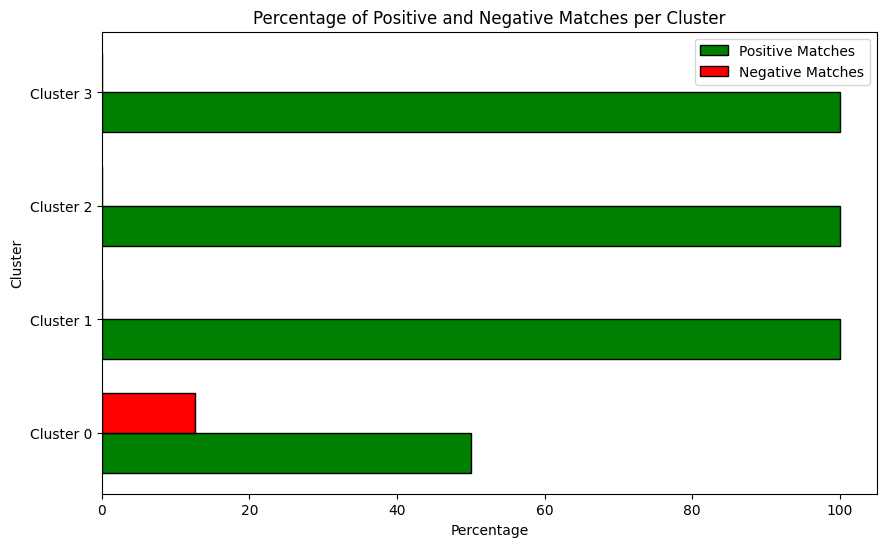

In [85]:
import numpy as np

import matplotlib.pyplot as plt

# Extract data from the results dictionary
clusters = list(results.keys())
positive_matches = [results[cluster]['perc_positive_examples_matched'] for cluster in clusters]
negative_matches = [results[cluster]['perc_negative_examples_matched'] for cluster in clusters]

# Define the bar width
bar_width = 0.35

# Define the positions of the bars
r1 = np.arange(len(clusters))
r2 = [x + bar_width for x in r1]

# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(r1, positive_matches, color='green', height=bar_width, edgecolor='black', label='Positive Matches')
ax.barh(r2, negative_matches, color='red', height=bar_width, edgecolor='black', label='Negative Matches')

# Add labels
ax.set_xlabel('Percentage')
ax.set_ylabel('Cluster')
ax.set_title('Percentage of Positive and Negative Matches per Cluster')
ax.set_yticks([r + bar_width / 2 for r in range(len(clusters))])
ax.set_yticklabels([f'Cluster {cluster}' for cluster in clusters])
ax.legend()

# Show the plot
plt.show()